### Convolutional Neural Network (CNN) with Tensorflow

# Identyfy objects in CIFAR10 dataset. 

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. There are 6,000 images of each class.

The 10 different classes are- 

Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck


In [1]:
# Make it work with python2 as well
from __future__ import print_function, division
from builtins import range

# Needed imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
cifar10 = tf.keras.datasets.cifar10

(XtrainOrig, YtrainOrig),(XtestOrig, YtestOrig) = cifar10.load_data()
catagMap = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

### Display Samples from dataset

Image catagory for displayed images:
Frog	Automobile	Deer	Truck	Deer	
Truck	Bird	Horse	Truck	Cat	
Truck	Horse	Horse	Cat	Frog	


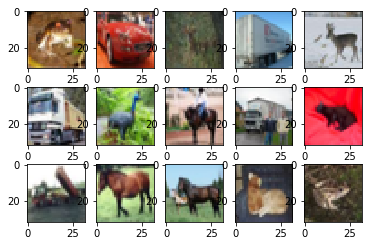

XtrainOrig.shape = (50000, 32, 32, 3) 		YtrainOrig.shape = (50000, 1)
XtestOrig.shape = (10000, 32, 32, 3) 		YtestOrig.shape = (10000, 1)


In [3]:
f, axarr = plt.subplots(3, 5)
print("Image catagory for displayed images:")
for i in range(3):
    for j in range(5):
        index = i + 5*j
        print(catagMap[YtrainOrig[index][0]], end='\t')
        axarr[i, j].imshow(XtrainOrig[index], cmap='gray')
    print()
plt.show()

print("XtrainOrig.shape =", XtrainOrig.shape, "\t\tYtrainOrig.shape =", YtrainOrig.shape)
print("XtestOrig.shape =", XtestOrig.shape, "\t\tYtestOrig.shape =", YtestOrig.shape)


### Prepare dataset for learning

Reshape the vector to add dimention for color channel. Here we have only one color channel. 
Then convert the pixel values in range 0 to 1 (float).

In [4]:
# Divide by 255.0
Xtrain = np.divide(XtrainOrig, 255.0)
Xtest = np.divide(XtestOrig, 255.0)
Ytrain, Ytest = YtrainOrig, YtestOrig

# Convert columar indicator vector to binary indicator matrix.
# Ex. Y = [2, 1, 0]
# return T = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
def conv_indicator_to_matrix(Y, numClasses):
    N = len(Y)
    T = np.zeros((N, numClasses))
    for i in range(N):
        T[i, int(Y[i])] = 1
    return T

# Number of Catagories
numCatag = 10

Ytrain_ind = conv_indicator_to_matrix(YtrainOrig, numCatag).astype(np.float32)
Ytest_ind = conv_indicator_to_matrix(YtestOrig, numCatag).astype(np.float32)

print("Xtrain.shape =", Xtrain.shape, "\t\tYtrain_ind.shape =", Ytrain_ind.shape)
print("Xtest.shape =", Xtest.shape, "\t\tYtest_ind.shape =", Ytest_ind.shape)


Xtrain.shape = (50000, 32, 32, 3) 		Ytrain_ind.shape = (50000, 10)
Xtest.shape = (10000, 32, 32, 3) 		Ytest_ind.shape = (10000, 10)


### Defining the Convolutional Neural Network (CNN) with two convolutional layers

In [5]:
# H - Hight of image, W - Width of image, C - number of color channels
# Ntr - Number of samples in traing set
# Ntt - Number of samples in test set
Ntr, H, W, C = Xtrain.shape
Ntt = Xtest.shape[0]
# Pool size for max pooling
poolsz = (2, 2)

M = 300 # Number of nodes in fully connected layer
# Number of nodes in output layer, this is equal to number of catagories in the data
K = numCatag


def initFilter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) 
    #     + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    return w.astype(np.float32)

C1_FilterWidth, C1_FilterHight = 5, 5
C1_NumFeatureMaps = 25
C1_OutWidth = W // poolsz[0]  # Devide for pooling
C1_OutHight = H // poolsz[1]  # Devide for pooling
#C1_OutWidth = (H - (C1_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C1_OutHight = (H - (C1_FilterHight -1)) / poolsz[1]  # Devide for pooling

C2_FilterWidth, C2_FilterHight = 5, 5
C2_NumFeatureMaps = 100
C2_OutWidth = C1_OutWidth // poolsz[0]  # Devide for pooling
C2_OutHight = C1_OutHight // poolsz[1]  # Devide for pooling
#C2_OutWidth = (C1_OutWidth - (C2_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C2_OutHight = (C1_OutHight - (C2_FilterHight -1)) / poolsz[1]  # Devide for pooling

# Initial weights and bias for convolutional layers
W1_shape = (C1_FilterWidth, C1_FilterHight, C, C1_NumFeatureMaps)
W1_init = initFilter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (C2_FilterWidth, C2_FilterHight, C1_NumFeatureMaps, C2_NumFeatureMaps)
W2_init = initFilter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

# Initial weights and bias for fully connected layer
W3_inSize = C2_NumFeatureMaps * C2_OutWidth * C2_OutHight
W3_init = np.random.randn(W3_inSize, M) / np.sqrt(W3_inSize + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)


# Define placeholders for inputs.
tfX = tf.placeholder(tf.float32, shape=(None, H, W, C), name='X')
tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')

# Variable for neural network weights. These are updated by Tensorflow during training.
# These weights are learned during training.
W1 = tf.Variable(W1_init.astype(np.float32), name="W1")
b1 = tf.Variable(b1_init.astype(np.float32), name="b1")
W2 = tf.Variable(W2_init.astype(np.float32), name="W2")
b2 = tf.Variable(b2_init.astype(np.float32), name="b2")
W3 = tf.Variable(W3_init.astype(np.float32), name="W3")
b3 = tf.Variable(b3_init.astype(np.float32), name="b3")
W4 = tf.Variable(W4_init.astype(np.float32), name="W4")
b4 = tf.Variable(b4_init.astype(np.float32), name="b4")

def convpool(X, W, b, psz):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, psz[0], psz[1], 1], strides=[1, psz[0], psz[1], 1], padding='SAME')
    return tf.nn.relu(pool_out)

Z1 = convpool(tfX, W1, b1, poolsz)
Z2 = convpool(Z1, W2, b2, poolsz)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, shape=[-1, np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Y_bar = tf.matmul(Z3, W4) + b4 # In Tensorflow, the cost function includes the softmax, so not needed here.



lr = 0.001
reg = 0.01

# define the cost function and prediction
# softmax_cross_entropy_with_logits take in the "logits"
# if we wanted to know the actual output of the neural net,
# we can pass "Y_bar" into tf.nn.softmax(logits)
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_bar, labels=tfY))
# cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y_bar,labels=tfY))

# we don't implement the learning algorithm ourselves.
# We use the RMSprop optimizer provided by Tensorflow. It includes momentum as well.
train_op = tf.train.RMSPropOptimizer(lr, decay=(1-reg), momentum=0.9).minimize(cost)

# We'll use this to calculate the error rate
predict_op = tf.argmax(Y_bar, 1)


### Training the neural network with Stochastic Gradient Descent using mini batches


In [ ]:
def error_rate(p, t):
    return np.mean(p != t)

max_iter = 10
log_period = 25
batch_sz = 100
n_batches = Ntr // batch_sz

#t0 = datetime.now()

costs = []
W1_val = None
W2_val = None

init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for epoch in range(max_iter):
        first = 1
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

            # Compute cost on test set to see the learning progress
            if j % log_period == 0:
                #tr_cost = session.run(cost, feed_dict={tfX: Xtrain, tfY: Ytrain_ind})
                tt_cost = session.run(cost, feed_dict={tfX: Xtest, tfY: Ytest_ind})
                #costs.append([tr_cost, tt_cost])
                costs.append(tt_cost)
                if first:
                    first = 0
                    tr_pred, tr_err = 0, 0
                    #tr_pred = session.run(predict_op, feed_dict={tfX: Xtrain})
                    #tr_err = error_rate(prediction, Ytrain)
                    tt_pred = session.run(predict_op, feed_dict={tfX: Xtest})
                    tt_err = error_rate(prediction, Ytest)
                    print("Cost / err at epoch %d:\ttrain(%.3f / %.3f) test(%.3f / %.3f)"
                          % (epoch, tr_cost, tr_err, tt_cost, tt_err))
    
    W1_val = W1.eval()
    W2_val = W2.eval()
    
    tt_pred = session.run(predict_op, feed_dict={tfX: Xtest})
    tt_err = error_rate(tt_pred, Ytest)
    print("Prediction error with test set =\t", tt_err)
    tr_pred = session.run(predict_op, feed_dict={tfX: Xtrain})
    tr_err = error_rate(tr_pred, Ytrain)
    print("Prediction error with training set =\t", tr_err)



In [ ]:
plt.plot(costs)
plt.show()



In [ ]:
W1_val = W1_val.transpose(3, 2, 0, 1)
W2_val = W2_val.transpose(3, 2, 0, 1)

# visualize W1 (20, 3, 5, 5)
# W1_val = W1.get_value()
grid = np.zeros((8*5, 8*5))
m = 0
n = 0
for i in range(20):
    for j in range(3):
        filt = W1_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 8:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W1")
plt.show()

# visualize W2 (50, 20, 5, 5)
# W2_val = W2.get_value()
grid = np.zeros((32*5, 32*5))
m = 0
n = 0
for i in range(50):
    for j in range(20):
        filt = W2_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 32:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W2")
plt.show()


